<a href="https://colab.research.google.com/github/kenken0830/Graphing/blob/main/in_painting_with_stable_diffusion_using_diffusers_with_canvas_drawing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HuggingFaceにログイン

In [2]:
#@title HuggingFaceにログイン
from google.colab import output
output.enable_custom_widget_manager()

!pip install -qq git+https://github.com/huggingface/diffusers 

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


# パッケージのインストールやモデルの読み込み（2分くらい）


In [3]:
#@title diffusersなどパッケージのインストール
!git clone https://github.com/huggingface/diffusers --quiet
!pip install -qq transformers ftfy

     |████████████████████████████████| 4.9 MB 14.6 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 6.6 MB 53.5 MB/s 


In [4]:
#@title RealESRGANパッケージのインストール
!git clone https://github.com/xinntao/Real-ESRGAN.git --quiet
%cd /content/Real-ESRGAN
# Set up the environment
!pip install -qq basicsr facexlib gfpgan -r requirements.txt
!python setup.py -q develop
# Download the pre-trained model
!wget -q https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
%cd /content

/content/Real-ESRGAN
     |████████████████████████████████| 172 kB 14.2 MB/s 
     |████████████████████████████████| 59 kB 7.7 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 5.9 MB 61.1 MB/s 
     |████████████████████████████████| 190 kB 72.1 MB/s 
     |████████████████████████████████| 177 kB 72.1 MB/s 
/content


In [5]:
#@title StableDiffusionのモデル読み込み
fp16 = True #@param {type:"boolean"}

import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    if fp16:
        revision = "fp16"
        torch_dtype = torch.float16
    else:
        revision = "main"
        torch_dtype = torch.float32
else:
    revision = "main"
    torch_dtype = torch.float32

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision=revision, 
    torch_dtype=torch_dtype,
    use_auth_token=True
).to(device)

def inpaint(p, init_image, mask_image=None, strength=0.75, num_inference_steps=50, guidance_scale=7.5, generator=None, num_samples=1, n_iter=1):
    all_images = []
    for _ in range(n_iter):
        with torch.autocast(device):
            images = pipe(
                prompt=[p] * num_samples,
                init_image=init_image,
                mask_image=mask_image,
                strength=strength,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator,
            )
        for sample, nsfw_content_detected in zip(images["sample"], images["nsfw_content_detected"]):
            if not nsfw_content_detected:
                im  = PIL.Image.composite(sample, init_image, mask_image.convert('L'))
                all_images.append(im)
            else:
                all_images.append(sample)
    return all_images

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [6]:
#@title キャンバスでお絵描きする機能の読み込み
from IPython.display import display, Javascript, HTML
from google.colab import files
from google.colab.output import eval_js
from base64 import b64encode, b64decode
import os
import cv2
import numpy as np

class CanvasControl(object):
  def __init__(self, width, height, id):
    self.id = id
    self.width = width
    self.height = height
    self.upload_filename = f'/content/uploaded_{id}.png'
    self.save_filename = f'/content/saved_{id}.png'

    self.init_html()
    self.init_js()

    if id == 'mask_image':
      self.imread('/content/saved_init_image.png', id='init_image')
    
    if os.path.isfile(self.save_filename):
      self.imread(self.save_filename)
    elif os.path.isfile(self.upload_filename):
      self.imread(self.upload_filename)
    else:
      if id == 'mask_image':
        img = self.grab_cut_first()
      else:
        img = self.get_white_screen()
      cv2.imwrite(self.save_filename, img)
      self.imread(self.save_filename)

  def get_white_screen(self):
      img = np.zeros((self.height, self.width, 3), np.uint8)
      img.fill(255)
      return img

  def grab_cut_first(self):
      img = cv2.imread('/content/saved_init_image.png')
      mask = np.zeros(img.shape[:2],np.uint8)
      rect = (1, 1, self.width, self.height)
      bgdModel = np.zeros((1,65),np.float64)
      fgdModel = np.zeros((1,65),np.float64)
      cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
      mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
      white = self.get_white_screen()
      img = white*mask2[:,:,np.newaxis]
      return img

  def grab_cut_imwrite(self, filename):
      img = self.grab_cut_first()
      cv2.imwrite(filename, img)
      self.imread(filename)

  def init_html(self):
    grab_cut = '' if self.id == 'mask_image' else 'hidden'
    
    html = f'''
      <div id="stage">
        <canvas id="init_image"></canvas>
        <canvas id="mask_image"></canvas>
      </div>
      <div>
        <label for="strokeColor">ペンの色</label>
        <input type="color" value="#FFFFFF" id="strokeColor">
        <label for="fillColor">塗りつぶしの色</label>
        <input type="color" value="#000000" id="fillColor">
      </div>
      <div class="slidecontainer">
      <label for="lineWidth" id="lineWidthLabel">16px</label>
        <input type="range" min="1" max="64" value="16" class="slider" id="lineWidth">
      </div>
      <div>
        <button id="fill_screen">塗りつぶし</button>
        <button id="negative_positive_inversion">ネガポジ反転</button>
        <button id="grab_cut" {grab_cut}>グラブカット</button>
      </div>
      <div>
        <button id="upload_uploaded_image">画像アップロード -> uploaded_{self.id}.png</button>
        <button id="load_uploaded_image">アップした画像を読み込み -> uploaded_{self.id}.png</button>
      </div>
      <div>
        <button id="save_saved_image">描いた画像を保存 -> saved_{self.id}.png</button>
        <button id="load_saved_image">描いた画像を読み込み -> saved_{self.id}.png</button>
      </div>
    '''
    css = '''
      <style>
        #stage {
          width: %spx;
          height: %spx;
          position: relative;
          border: 2px solid black;
        }
        canvas { position: absolute; }
        #mask_image { z-index: 2; }
        #init_image { z-index: 1; }
      </style>
    ''' % (self.width, self.height)
    html_css = HTML(html + css)
    display(html_css)

  def init_js(self):
    js = Javascript('''
    async function drawImage(id, width, height, read_filename, write_filename) {
      const canvas = document.getElementById(id);
      canvas.width = width;
      canvas.height = height;
      const ctx = canvas.getContext('2d');
      const strokeColor = document.querySelector('#strokeColor');
      const fillColor = document.querySelector('#fillColor');
      const slider = document.getElementById("lineWidth");
      ctx.strokeStyle = strokeColor.getAttribute('value');
      ctx.fillStyle = fillColor.getAttribute('value');
      ctx.lineWidth = slider.getAttribute('value');
      if (id == 'mask_image') {
        ctx.globalAlpha = 0.5;
      }
      function updateStroke(event){
        ctx.strokeStyle = event.target.value;
        strokeColor.setAttribute("value", event.target.value); 
      }
      function updateFillColor(event){
        ctx.fillStyle = event.target.value;
        fillColor.setAttribute("value", event.target.value); 
      }
      slider.oninput = function() {
        ctx.lineWidth = this.value;
        slider.setAttribute("value", this.value); 
        lineWidthLabel.innerHTML = `${this.value}px`;
      }
      strokeColor.addEventListener("change", updateStroke, false);
      fillColor.addEventListener("change", updateFillColor, false);
      
      const fill_screen_button = document.querySelector('#fill_screen')
      const negative_positive_inversion_button = document.querySelector('#negative_positive_inversion')
      const grab_cut_button = document.querySelector('#grab_cut')
      const upload_uploaded_image_button = document.querySelector('#upload_uploaded_image')
      const load_uploaded_image_button = document.querySelector('#load_uploaded_image')
      const save_saved_image_button = document.querySelector('#save_saved_image')
      const load_saved_image_button = document.querySelector('#load_saved_image')
      const mouse = {x: 0, y: 0}
      canvas.addEventListener('mousemove', function(e) {
        mouse.x = e.pageX - this.offsetLeft
        mouse.y = e.pageY - this.offsetTop
      })
      canvas.onmousedown = ()=>{
        ctx.beginPath()
        ctx.moveTo(mouse.x, mouse.y)
        canvas.addEventListener('mousemove', onPaint)
      }
      canvas.onmouseup = ()=>{
        canvas.removeEventListener('mousemove', onPaint)
      }
      const onPaint = ()=>{
        ctx.lineTo(mouse.x, mouse.y)
        ctx.stroke()
      }

      fill_screen_button.onclick = ()=>{
        ctx.clearRect(0, 0, canvas.width, canvas.height);
        ctx.fillRect(0, 0, canvas.width, canvas.height);
      }

      negative_positive_inversion_button.onclick = ()=>{
        const src = ctx.getImageData(0, 0, canvas.width, canvas.height);
        const dst = ctx.createImageData(canvas.width, canvas.height);

        //ネガポジ変換
        for (let i = 0; i < src.data.length; i=i+4) {
            dst.data[i]   = 255 - src.data[i];    //R
            dst.data[i+1] = 255 - src.data[i+1];  //G
            dst.data[i+2] = 255 - src.data[i+2];  //B
            dst.data[i+3] = src.data[i+3];        //A
        }
        ctx.putImageData(dst, 0, 0);
      }

      grab_cut_button.onclick = async ()=>{
        const result = await google.colab.kernel.invokeFunction(
          'notebook.grab_cut', // The callback name.
          [read_filename], // The arguments.
          {}); // kwargs
      }

      upload_uploaded_image_button.onclick = async ()=>{
        const result = await google.colab.kernel.invokeFunction(
          'notebook.upload', // The callback name.
          {}); // kwargs
        load_uploaded_image_button.onclick()
      }

      load_uploaded_image_button.onclick = async ()=>{
        const result = await google.colab.kernel.invokeFunction(
          'notebook.imread', // The callback name.
          [read_filename], // The arguments.
          {}); // kwargs
        save_saved_image_button.onclick()
      }
      
      save_saved_image_button.onclick = async ()=>{
        const result = await google.colab.kernel.invokeFunction(
          'notebook.imwrite', // The callback name.
          [write_filename], // The arguments.
          {}); // kwargs
      }

      load_saved_image_button.onclick = async ()=>{
        const result = await google.colab.kernel.invokeFunction(
          'notebook.imread', // The callback name.
          [write_filename], // The arguments.
          {}); // kwargs
      }

      fill_screen_button.onclick()
    }
    ''')
    display(js)
    eval_js(f'drawImage("{self.id}", "{self.width}", "{self.height}", "{self.upload_filename}", "{self.save_filename}")') 

  def imwrite(self, filename):
    js = Javascript('''
    async function writeImage(id) {
      const canvas = document.getElementById(id);
      const ctx = canvas.getContext('2d');
      const backupData = ctx.getImageData(0, 0, canvas.width, canvas.height);
      if (id == 'mask_image') {
        const imageData = ctx.getImageData(0, 0, canvas.width, canvas.height);
        const data = imageData.data;
        for(let i = 0; i < data.length; i += 4){ 
          data[i + 3] = 255;
        }
        imageData.data = data;
        ctx.putImageData(imageData, 0, 0); 
      }
      const png = canvas.toDataURL('image/png');
      if (id == 'mask_image') {
        ctx.putImageData(backupData, 0, 0); 
      }

      return png;
    }
    ''')

    display(js)
    data = eval_js(f'writeImage("{self.id}")')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
      f.write(binary)

  def imread(self, filename, id=None):
    if id is None:
      id = self.id
    js = Javascript('''
    async function showImage(id, data, width, height) {
      const canvas = document.getElementById(id);
      const ctx = canvas.getContext('2d');
      const strokeColor = document.querySelector('#strokeColor');
      const fillColor = document.querySelector('#fillColor');
      const slider = document.getElementById("lineWidth");
      const image = new Image();
      image.src = data;
      image.onload = () => {
        canvas.width = width;
        canvas.height = height;
        if (id == 'mask_image') {
          ctx.globalAlpha = 0.5;
        }
        ctx.drawImage(image, 0, 0, width, height);
        ctx.strokeStyle = strokeColor.getAttribute('value');
        ctx.fillStyle = fillColor.getAttribute('value');
        ctx.lineWidth = slider.getAttribute('value');
      };
    }
    ''')

    image = cv2.imread(filename)
    scaled_img = self.resize_and_pad(image, (self.height,  self.width), 127)
    height, width = scaled_img.shape[:2]
    ret, data = cv2.imencode('.png', scaled_img)
    data = b64encode(data) 
    data = data.decode()
    data = 'data:image/png;base64,' + data

    display(js)
    eval_js(f'showImage("{id}", "{data}", "{width}", "{height}")') 

  def upload(self):
    uploaded = files.upload()
    uploaded = list(uploaded.keys())
    assert len(uploaded) == 1
    os.rename(uploaded[0], self.upload_filename) 
  
  def resize_and_pad(self, img, size, padColor=0):
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img


# ここから操作して画像をアップロードしたりする

In [7]:
#@title 初期画像のアップロード、お絵描きも可能
from google.colab import output
ccii = CanvasControl(id="init_image", width=512, height=512)
output.register_callback('notebook.upload', ccii.upload)
output.register_callback('notebook.imread', ccii.imread)
output.register_callback('notebook.imwrite', ccii.imwrite)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving 511079.jpg to 511079.jpg


Saving ダウンロード (1).png to ダウンロード (1).png


Saving ダウンロード (1).png to ダウンロード (1).png


<IPython.core.display.Javascript object>

Saving man2-removebg-preview.png to man2-removebg-preview.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
#@title マスク画像の作成、読み込みも可能　※白い領域が描き換わる
from google.colab import output
ccmi = CanvasControl(id="mask_image", width=512, height=512)
output.register_callback('notebook.upload', ccmi.upload)
output.register_callback('notebook.grab_cut', ccmi.grab_cut_imwrite)
output.register_callback('notebook.imread', ccmi.imread)
output.register_callback('notebook.imwrite', ccmi.imwrite)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using seed: 59677


0it [00:00, ?it/s]

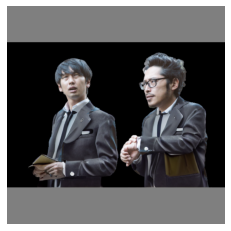

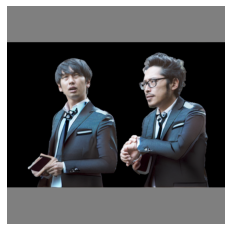

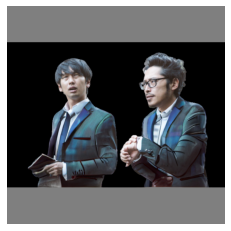

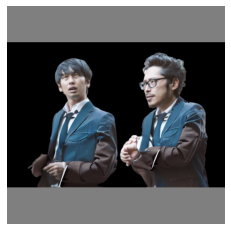

In [12]:
import torch
import PIL

prompt = "concept idea, kawaii fashion, beautiful face" #@param {type: "string"}
strength=0.5 #@param {type:"slider", min:0, max:1, step:0.01}
num_inference_steps= 108 #@param {type:"slider", min:1, max:200, step:1}
guidance_scale= 11.6 #@param {type:"slider", min:1, max:20, step:0.1}
num_samples = 4 #@param [1, 2, 3, 4] {type:"raw"}
n_iter = 1 #@param [1, 2, 3, 4] {type:"raw"}
random_seed = True #@param {type:"boolean"}
seed = 1000 #@param {type:"raw"}

if random_seed is True:
    seed = int.from_bytes(os.urandom(2), "big")
print(f"Using seed: {seed}")

init_image = PIL.Image.open('/content/saved_init_image.png').convert("RGB")
mask_image = PIL.Image.open('/content/saved_mask_image.png').convert("RGB")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = torch.Generator(device=device).manual_seed(seed) # change the seed to get different results
images = inpaint(prompt, init_image, mask_image, strength=strength, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, generator=generator, num_samples=num_samples, n_iter=n_iter)
torch.cuda.empty_cache()

import matplotlib.pyplot as plt
%matplotlib inline
for image in images:
    plt.figure()
    plt.axis('off')
    plt.imshow(image)

In [13]:
#@title 初期画像へsample_number番目の画像をコピー
sample_number = 2 #@param [1, 2, 3, 4] {type:"raw"}
import os

output_path = '/content/output/'
os.makedirs(output_path, exist_ok=True)
base_count = len(os.listdir(output_path))
for i, image in enumerate(images):
  image.save(f"{output_path}/{base_count:08}.png")
  base_count += 1
  if i ==  min(sample_number, len(images)) - 1:
    image.save("/content/saved_init_image.png")

In [14]:
#@title RealESRGANで4倍に拡大
%cd /content/Real-ESRGAN
!python inference_realesrgan.py -n RealESRGAN_x4plus -i '/content/saved_init_image.png' -o '/content/output' --face_enhance
%cd /content

/content/Real-ESRGAN
Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth" to /content/Real-ESRGAN/weights/RealESRGAN_x4plus.pth

100% 63.9M/63.9M [00:01<00:00, 41.7MB/s]
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" to /content/Real-ESRGAN/gfpgan/weights/detection_Resnet50_Final.pth

100% 104M/104M [00:04<00:00, 24.9